In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F?
from torch.utils.data import Dataset, DataLoader

from sklearn.preprocessing import MinMaxScaler
from tqdm.auto import tqdm

import os

import data_preprocess
from data_preprocess import *

/home/enishiwaki/miniconda3/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Object `F` not found.


### Importing data, plotting

In [2]:
#Reading csv, dropping NaNs
#data = read_csv_drop('/mnt/c/users/emily/Downloads/DataImpurityGAN.csv',['Primary ID'])
data = pd.read_csv(r'/mnt/c/users/emily/Downloads/sinewavedata.csv')

In [3]:
#Splitting data
#conditions, targets = split_target_condition(data, condition='Class')
conditions, targets = split_target_condition(data, condition='Pressure Condition')


#Scaling data, Putting split data into lists of tensors
conditions_tensor, target_tensor, scaler = minmax_scaler(conditions,targets, min=0, max=1)

shape of targets (all features without operating conditions): (10000, 45)
shape of conditions (operating conditions): (10000,)


In [31]:
BATCH_SIZE = 20
train_dataloader = data_batch_clean(target_tensor,conditions_tensor,168,BATCH_SIZE)

length of data: 10000
We have 59 samples with 168 datapoints in each.
dataloader: <torch.utils.data.dataloader.DataLoader object at 0x7f6e2a765ea0>
length of train_dataloader: 3 batches of 20 (batch_size) examples
number of total examples: 59 
each example containing... 
TARGET shape (number of timepoints): torch.Size([168, 45]) 
CONDITION shape (class 1 or 2): torch.Size([168, 1])


### Discriminator and Generator

In [32]:
# defining a disciminator model

from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # input shape is number of columns
        # output shape is 2 (for probability of 0 or 1)

        # pass concatenated target+conditions through nn.Sequential
        self.main = nn.Sequential(
            # input is INPUT SHAPE // number of columns/channels
            nn.Conv1d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            nn.Conv1d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=2,
                      padding=1,
                      bias=False),
            nn.LeakyReLU(negative_slope=0.2),
            nn.MaxPool1d(kernel_size=3,
                         stride=2,
                         padding=1),
            nn.Flatten(),
            nn.Dropout(p=0.2),
        )

        self.linearize = nn.Sequential(
            nn.Linear(in_features=hidden_units*21,
                      out_features=output_shape),
            nn.Sigmoid() # output of probability
        )

    def forward(self, target, conditions):
        """takes target and conditions as batches"""
        # concatenating and transposing
        data = torch.cat([target, conditions], axis=2)
        data_in = torch.transpose(data, 1, 2)

        # forward pass through nn.Main
        out = self.main(data_in)
        # forward pass through nn.linear + nn.sigmoid
        out = self.linearize(out)
    
        return out

In [33]:
# defining a generator model

from torch import nn

class Generator(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        # input shape is number of columns
        # output shape is 2 (for probability of 0 or 1)

        # pass concatenated target+conditions through nn.Sequential
        self.main = nn.Sequential(
            # input is INPUT SHAPE // number of columns/channels
            nn.ConvTranspose1d(in_channels=input_shape,
                               out_channels=hidden_units,
                               kernel_size=3,
                               stride=1,
                               padding=1),
            nn.ReLU(),
            nn.ConvTranspose1d(in_channels=hidden_units,
                               out_channels=hidden_units,
                               kernel_size=3,
                               stride=1,
                               padding=1),
            nn.ReLU(),
            nn.BatchNorm1d(num_features=hidden_units),
            nn.Conv1d(in_channels=hidden_units,
                      out_channels=45,
                      kernel_size=3,
                      stride=1,
                      padding=1)
    	)

        self.sigmoid = nn.Sigmoid()

    def forward(self, noise, conditions):
        """takes target and conditions as batches"""
        # concatenating and transposing
        data = torch.cat([noise, conditions], axis=2)
        data_in = torch.transpose(data, 1, 2)

        # forward pass through nn.Main
        out = self.main(data_in)

        # tranposing the data for activation function
        data_in = torch.transpose(out, 1, 2)

        # forward pass through nn.Activation
        out = self.sigmoid(data_in)
    
        return out

In [34]:
# # defining a generator model with RNN layer

# from torch import nn

# class Generator(nn.Module):
#     def __init__(self, input_size: int, hidden_size: int, num_layers):
#         super().__init__()
#         self.rnn = nn.RNN(input_size,hidden_size,num_layers,batch_first=True)
#         self.fc=nn.Linear(hidden_size,1)
#         self.sigmoid=nn.Sigmoid()
#         self.dropout = nn.Dropout(0.3)
#         self.relu = nn.ReLU()

#     def forward(self,target,condition):
#         x = torch.cat([target,condition],axis=2)
#         x,_=self.rnn(x)
#         x = self.fc(x)
#         x = self.relu(x)
#         x = self.dropout(x)
#         x= self.sigmoid(x)
#         return x.squeeze()

### Training Loop

In [35]:
netD = Discriminator(input_shape=46, hidden_units=8, output_shape=1)
netD

Discriminator(
  (main): Sequential(
    (0): Conv1d(46, 8, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (1): LeakyReLU(negative_slope=0.2)
    (2): Conv1d(8, 8, kernel_size=(3,), stride=(2,), padding=(1,), bias=False)
    (3): LeakyReLU(negative_slope=0.2)
    (4): MaxPool1d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Dropout(p=0.2, inplace=False)
  )
  (linearize): Sequential(
    (0): Linear(in_features=168, out_features=1, bias=True)
    (1): Sigmoid()
  )
)

In [36]:
netG = Generator(input_shape=46, hidden_units=8, output_shape=45)
netG

Generator(
  (main): Sequential(
    (0): ConvTranspose1d(46, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (1): ReLU()
    (2): ConvTranspose1d(8, 8, kernel_size=(3,), stride=(1,), padding=(1,))
    (3): ReLU()
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv1d(8, 45, kernel_size=(3,), stride=(1,), padding=(1,))
  )
  (sigmoid): Sigmoid()
)

In [37]:
loss_D_list = []
loss_G_list = []

epochs = 1000

netD.train()
netG.train()

# optimizer for discriminator and generator
optimizerD = torch.optim.Adam(netD.parameters(),lr=0.0005,betas=(0.5, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(),lr=0.0005,betas=(0.5, 0.999))


real_condition = torch.ones([BATCH_SIZE, 1], dtype=torch.float)
fake_condition = torch.zeros([BATCH_SIZE, 1], dtype=torch.float)

G_loss_fn = nn.MSELoss()
D_loss_fn = nn.BCELoss()

# Iterating through epochs
for epoch in tqdm(range(epochs)):

	# Iterating through batches (i: iterable int, target: target, condition: condition)
    for i, (target, condition) in enumerate(train_dataloader):
        # for iterating through only FULL BATCHES
        #print(len(condition))
        if len(condition) == BATCH_SIZE:

            # initializng fixed noise to generator
            fixed_noise = torch.randn((BATCH_SIZE,168, 45))

            #inputting the target to the generator to give it a "starting point"
            #conceptually not sure about this
            #fixed_noise = target[0:168*BATCH_SIZE][:].view(BATCH_SIZE,168,-1)
            '''
                Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            '''
            # Generating data and feeding it to the discriminator
            G_result = netG(fixed_noise,condition)
            D_fake_result = netD(G_result,condition)

            # Inputting real results into discriminator
            D_real_result = netD(target, condition)

            # Calculating the loss for the real and the generated data
            D_real_loss = D_loss_fn(D_real_result, real_condition)
            D_fake_loss = D_loss_fn(D_fake_result, fake_condition)

            # Back propagation
            D_train_loss = (D_real_loss + D_fake_loss) / 2
            netD.zero_grad()
            D_train_loss.backward()
            optimizerD.step()
            '''
                Update G network: maximize log(D(G(z)))
            '''
            new_condition = torch.ones([BATCH_SIZE,168, 1], dtype=torch.int)
            #new_condition = torch.LongTensor(BATCH_SIZE, 168, 1).random_(1, 2)
            G_result = netG(fixed_noise, new_condition)
            D_fake_result = netD(G_result, new_condition)
            G_train_loss = G_loss_fn(D_fake_result, real_condition)
            
            # Back propagation
            netD.zero_grad()
            netG.zero_grad()
            G_train_loss.backward()
            optimizerG.step()
        else:
            pass
        
    # per epoch, append loss info:
    loss_G_list.append(G_train_loss)
    loss_D_list.append(D_train_loss)

    # print progress per 10 epochs
    if (epoch+1) % 10 == 0:
                print(f"Epoch: {epoch+1}/{epochs} | D_loss: {D_train_loss:.4f} | G_loss: {G_train_loss:.4f}")
    else:
          pass

  0%|          | 0/1000 [00:00<?, ?it/s]

Epoch: 10/1000 | D_loss: 0.6565 | G_loss: 0.3459
Epoch: 20/1000 | D_loss: 0.6091 | G_loss: 0.3954
Epoch: 30/1000 | D_loss: 0.5622 | G_loss: 0.4362
Epoch: 40/1000 | D_loss: 0.5224 | G_loss: 0.4612
Epoch: 50/1000 | D_loss: 0.5012 | G_loss: 0.4615
Epoch: 60/1000 | D_loss: 0.4769 | G_loss: 0.4860
Epoch: 70/1000 | D_loss: 0.3906 | G_loss: 0.5420
Epoch: 80/1000 | D_loss: 0.3009 | G_loss: 0.6267
Epoch: 90/1000 | D_loss: 0.2529 | G_loss: 0.6622
Epoch: 100/1000 | D_loss: 0.2219 | G_loss: 0.7220
Epoch: 110/1000 | D_loss: 0.1750 | G_loss: 0.7238
Epoch: 120/1000 | D_loss: 0.1499 | G_loss: 0.7121
Epoch: 130/1000 | D_loss: 0.1123 | G_loss: 0.7373
Epoch: 140/1000 | D_loss: 0.1139 | G_loss: 0.7232
Epoch: 150/1000 | D_loss: 0.1241 | G_loss: 0.7105
Epoch: 160/1000 | D_loss: 0.1616 | G_loss: 0.6693
Epoch: 170/1000 | D_loss: 0.2233 | G_loss: 0.6649
Epoch: 180/1000 | D_loss: 0.3320 | G_loss: 0.4465
Epoch: 190/1000 | D_loss: 0.4991 | G_loss: 0.2581
Epoch: 200/1000 | D_loss: 0.4407 | G_loss: 0.2739
Epoch: 21

### Plotting Loss

In [38]:
# converting loss lists to numpy
D_loss = []
G_loss = []
for i, loss in enumerate(loss_D_list):
    d = loss.detach().numpy()
    D_loss.append(d)
for i, loss in enumerate(loss_G_list):
    g = loss.detach().numpy()
    G_loss.append(g)

# stacking arrays
D_loss_array = np.vstack(D_loss).flatten()
G_loss_array = np.vstack(G_loss).flatten()

loss_df = pd.DataFrame({
    'epochs': np.arange(0, epochs, epochs/len(D_loss_array)),
    'D_loss': D_loss_array,
    'G_loss': G_loss_array
})
loss_df.head()

,epochs,D_loss,G_loss
0,0.0,0.683648,0.291506
1,1.0,0.678168,0.293966
2,2.0,0.684454,0.293147
3,3.0,0.674169,0.301866
4,4.0,0.673807,0.306531


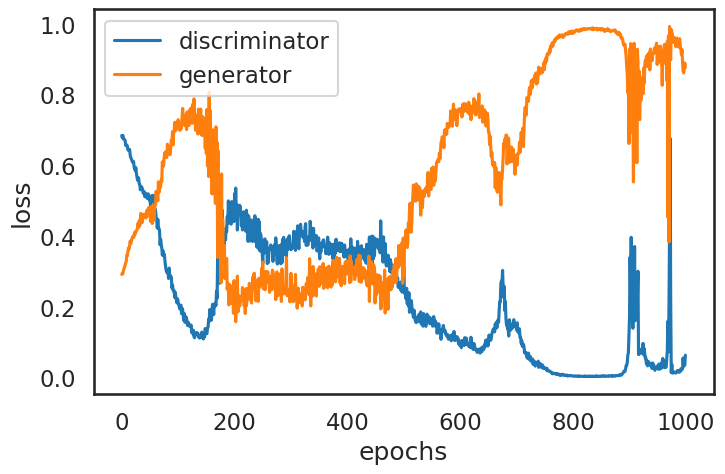

In [39]:
sns.set_context('talk')
sns.set_style('white')

fig, ax = plt.subplots(figsize=(8, 5))
sns.lineplot(data=loss_df, x='epochs', y='D_loss', label='discriminator')
sns.lineplot(data=loss_df, x='epochs', y='G_loss', label='generator')
ax.set_xlabel('epochs')
ax.set_ylabel('loss');

### Plotting generated features

In [40]:
input_noise = torch.rand(1, 10000, 45)
input_condition = torch.zeros(1, 10000, 1)

In [41]:
column_names = list(data.columns.values[0:45])
generated_samples = netG(input_noise, input_condition)
generated_data_array = generated_samples.detach().numpy().squeeze()
generated_data_unscaled = scaler.inverse_transform(generated_data_array)
generated_data_df = pd.DataFrame(generated_data_unscaled, columns=column_names)
print(f"generated_data: {generated_data_df.shape}")

generated_data: (10000, 45)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Time (hours)')

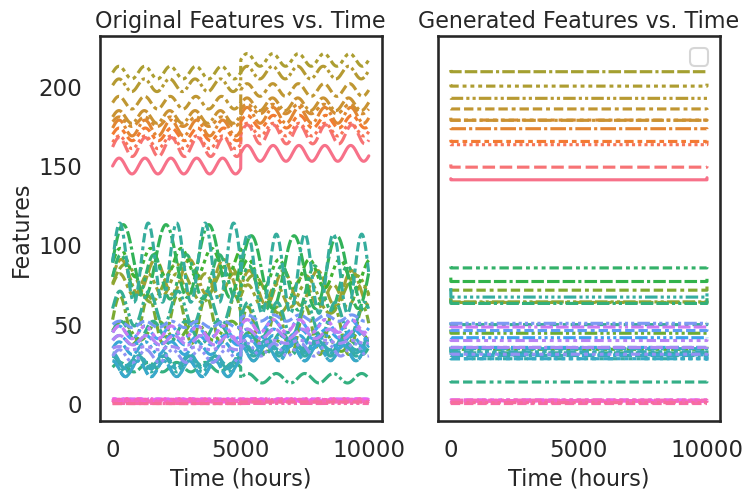

In [42]:
fig, ax = plt.subplots(1,2,figsize=(8,5),sharex=True,sharey=True)
sns.lineplot(data=data.iloc[0:,1:45], ax=ax[0],legend=False)
plt.legend()
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.30), ncols=3,fontsize=10)
ax[0].set_title('Original Features vs. Time',fontsize=16)
ax[0].set_xlabel('Time (hours)',fontsize=16)
ax[0].set_ylabel('Features',fontsize=16);

sns.lineplot(data=generated_data_df,legend=False,ax=ax[1])
#plt.legend(loc='lower center', bbox_to_anchor=(0, -2.35), ncols=2)
ax[1].set_title('Generated Features vs. Time',fontsize=16)
ax[1].set_xlabel('Time (hours)',fontsize=16)
#ax[1].set_ylabel('Features',fontsize=16);

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Text(0.5, 0, 'Time (hours)')

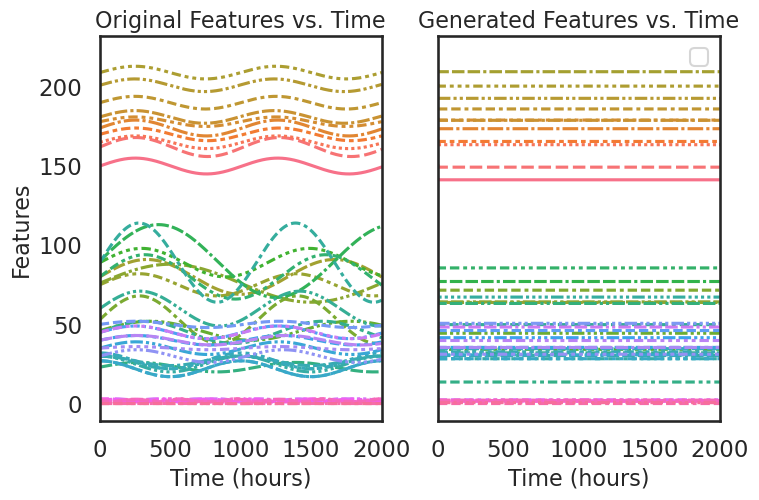

In [43]:
fig, ax = plt.subplots(1,2,figsize=(8,5),sharex=True,sharey=True)
sns.lineplot(data=data.iloc[0:,1:45], ax=ax[0],legend=False)
plt.legend()
#plt.legend(loc='lower center', bbox_to_anchor=(0.5, -1.30), ncols=3,fontsize=10)
ax[0].set_title('Original Features vs. Time',fontsize=16)
ax[0].set_xlabel('Time (hours)',fontsize=16)
ax[0].set_ylabel('Features',fontsize=16);
ax[0].set_xlim(0,2000)

sns.lineplot(data=generated_data_df,legend=False,ax=ax[1])
#plt.legend(loc='lower center', bbox_to_anchor=(0, -2.35), ncols=2)
ax[1].set_title('Generated Features vs. Time',fontsize=16)
ax[1].set_xlabel('Time (hours)',fontsize=16)
#ax[1].set_ylabel('Features',fontsize=16);